<a href="https://colab.research.google.com/github/lmgrj/Deep-Learning-avec-PyTorch/blob/main/DeepLearning_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>WISD&EID2/Deep Learning</center></h1> 

<center><h1>TP 4 </center><h1>

<center><h1>Autoencoders</center><h1>


---
By: **Lamgarraj Mohamed**   &   **Yazid Tagnaouti Moumnani**


---


# PRACTICAL LECTURE 4

# PART1. Autoencoders

1. Import libraries

In [ ]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

2. Convert vector to image.
The following function allows to convert a vector to a image


In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

3. We now write a function which allows to display the images using the omshow() function.

In [ ]:
def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

4. Define a data loading step and load the MNIST dataset

In [ ]:
batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataloader

5. Fix the used device

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

6. Define the Autoencoder model architecture and reconstruction loss
with : 
n = 28 x 28 = 784

A. Use d = 30  for standard AE (under-complete hidden layer)

B. Use d = 500 for denoising AE (over-complete hidden layer)

C. Explain the difference between standard AE and denoising AE.
Analyse the results and conclude.


<center> <h2> Réponse </center>

---
**Les encodeurs automatiques de débruitage créent une copie corrompue de l'entrée en introduisant du bruit. Cela permet d'éviter que les auto-encodeurs copient l'entrée vers la sortie sans apprendre les fonctionnalités des données. Ces auto-encodeurs prennent une entrée partiellement corrompue lors de la formation pour récupérer l'entrée originale non déformée. Le modèle apprend un champ vectoriel pour mapper les données d'entrée vers une variété dimensionnelle inférieure qui décrit les données naturelles pour annuler le bruit ajouté.**

<h3>pourquoi un denoising AE et pas un Standart AE :</h3>

 

*   Il a été introduit pour obtenir une bonne représentation. Une tellereprésentation est celle qui peut être obtenue de manière robuste à partir d'une entrée corrompue et qui sera utile pour récupérer l'entrée propre correspondante.
*   La corruption de l'entrée peut être effectuée de manière aléatoire en faisant en sorte qu'une partie de l'entrée soit nulle. Les nœuds restants copient l'entrée vers l'entrée bruitée.

*   Minimise la fonction de perte entre le nœud de sortie et l'entrée corrompue.
La configuration d'un auto-encodeur de débruitage à un seul thread est facile.
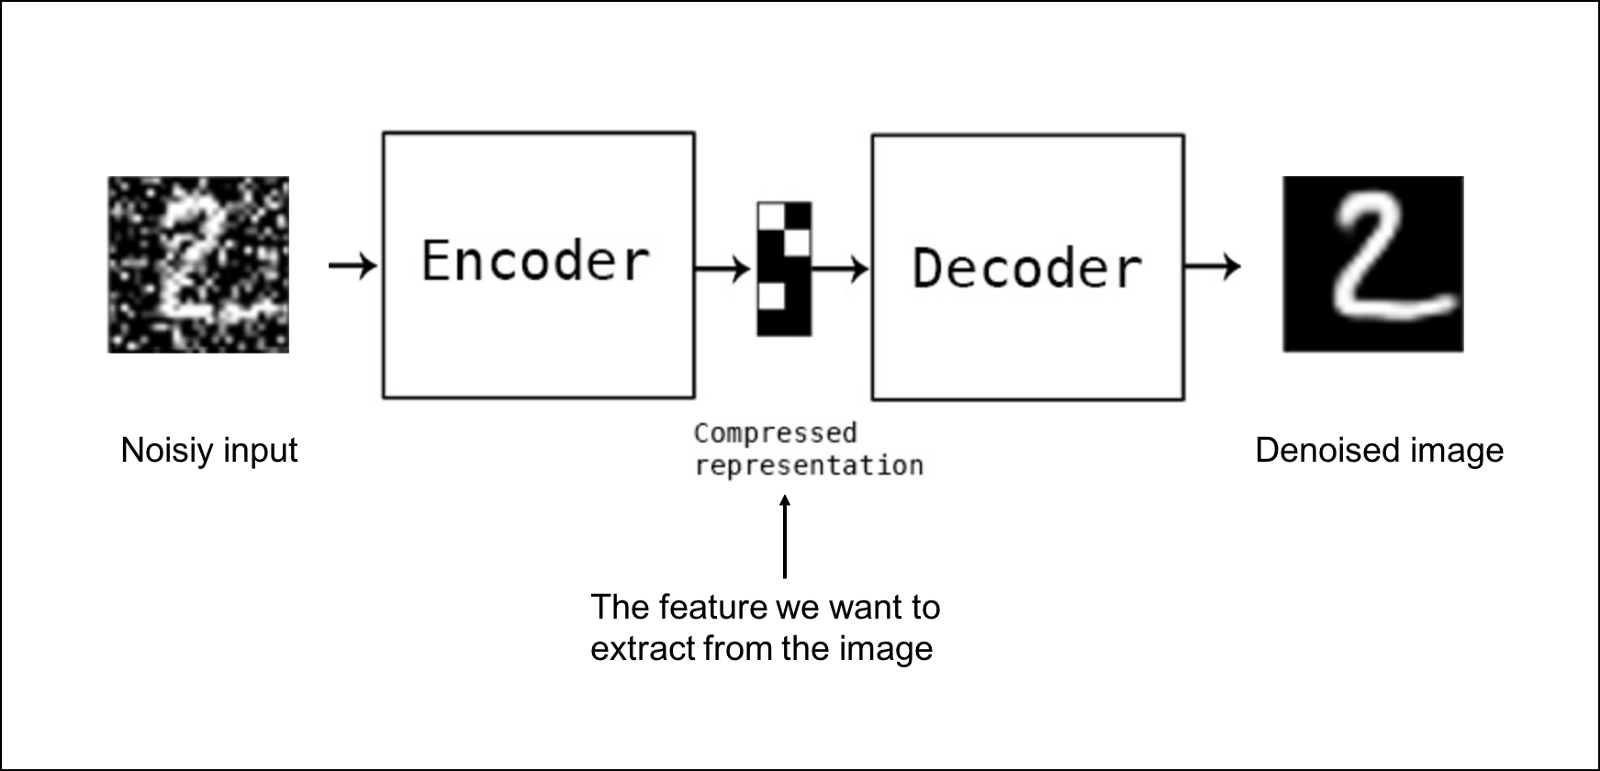

---




In [ ]:
d=30
#d = 500 #activer ce ligne et recompiler pour le denoising autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

7. Configure the optimiser. We use here : learning_rate equals to 1e-3

In [ ]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

8. Train the standard autoencoder and the denoising autoencoder using the following code :


# **standard AE**

epoch [1/10], loss:0.2077
epoch [2/10], loss:0.1542
epoch [3/10], loss:0.1239
epoch [4/10], loss:0.1010
epoch [5/10], loss:0.0895
epoch [6/10], loss:0.0924
epoch [7/10], loss:0.0820
epoch [8/10], loss:0.0806
epoch [9/10], loss:0.0772
epoch [10/10], loss:0.0772


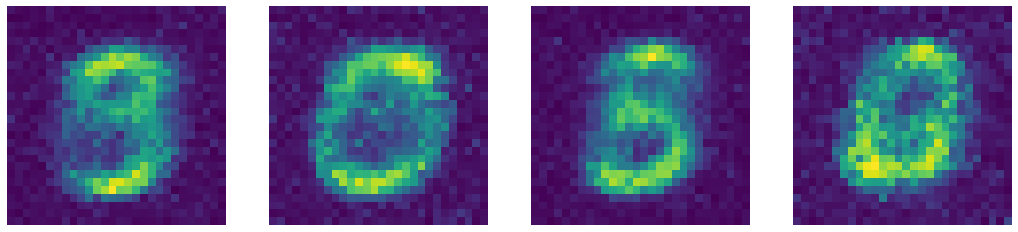

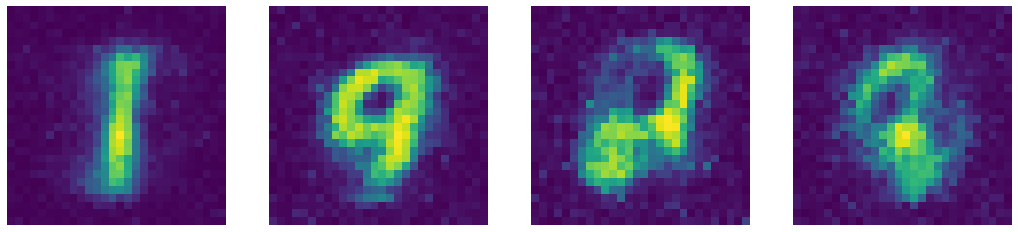

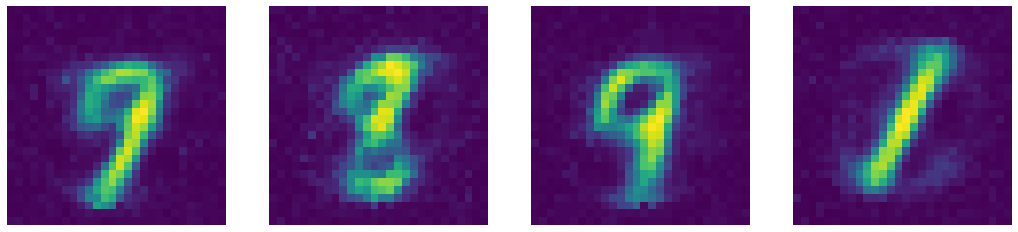

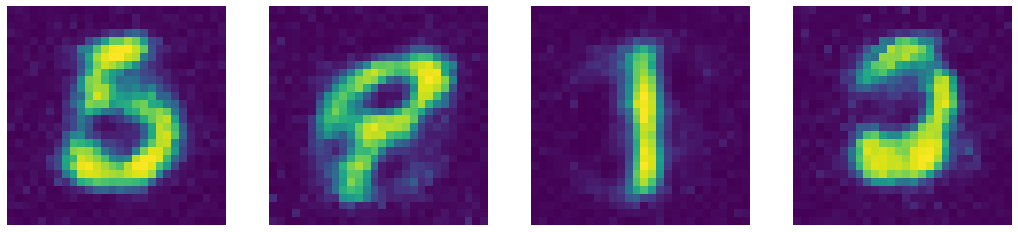

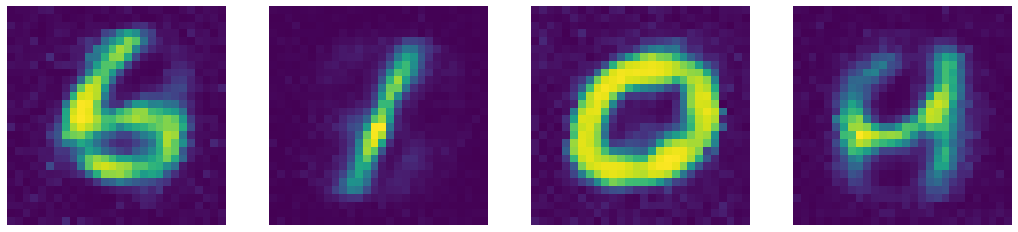

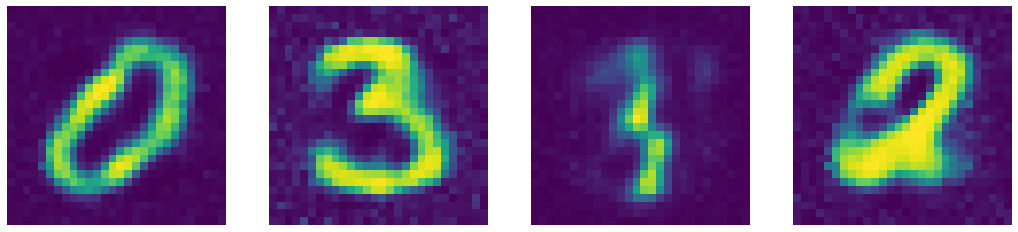

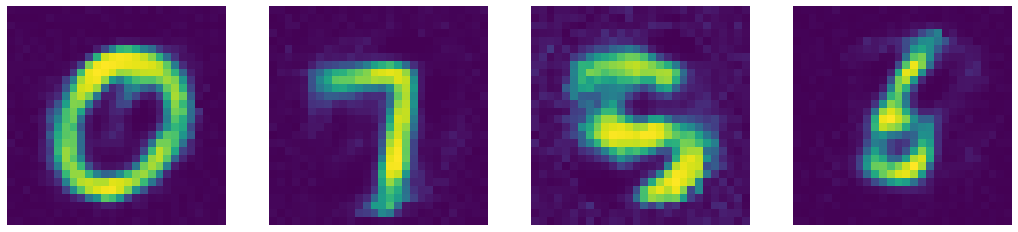

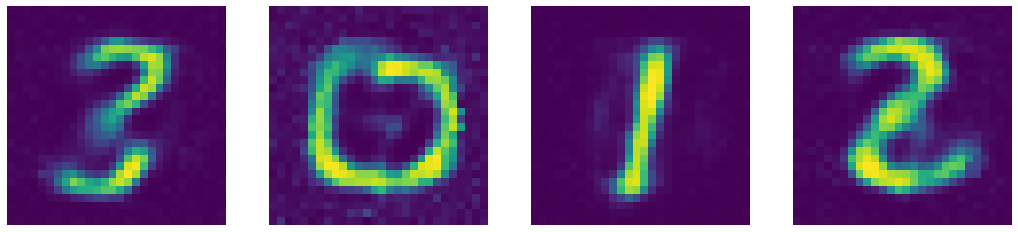

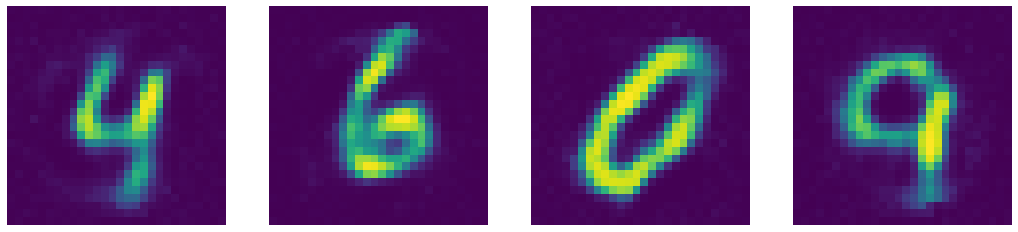

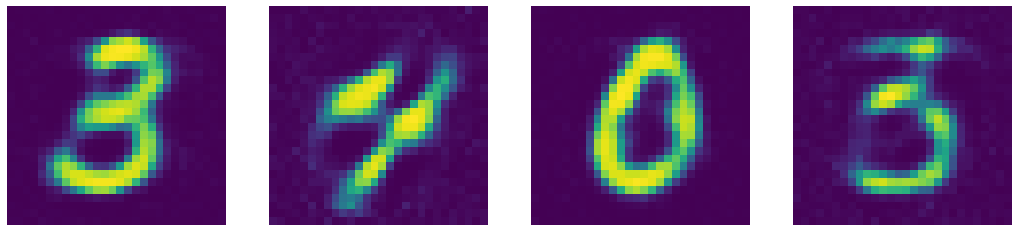

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)

# **denoising AE**

epoch [1/10], loss:0.0990
epoch [2/10], loss:0.0965
epoch [3/10], loss:0.1013
epoch [4/10], loss:0.0952
epoch [5/10], loss:0.0873
epoch [6/10], loss:0.0915
epoch [7/10], loss:0.0925
epoch [8/10], loss:0.0892
epoch [9/10], loss:0.0846
epoch [10/10], loss:0.0889


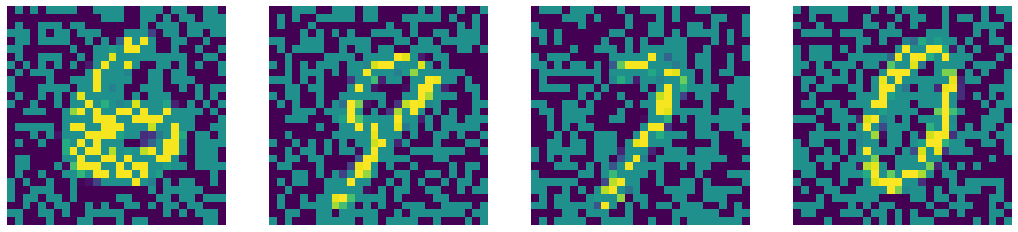

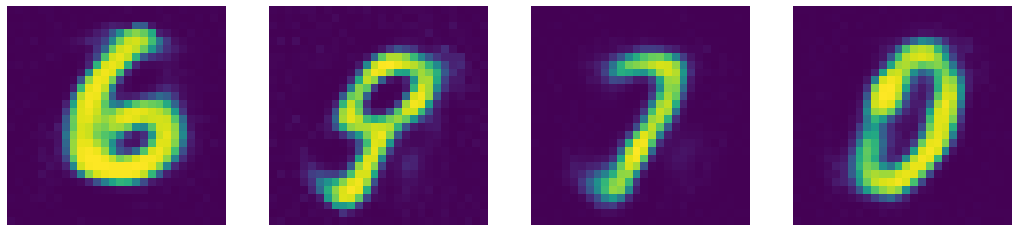

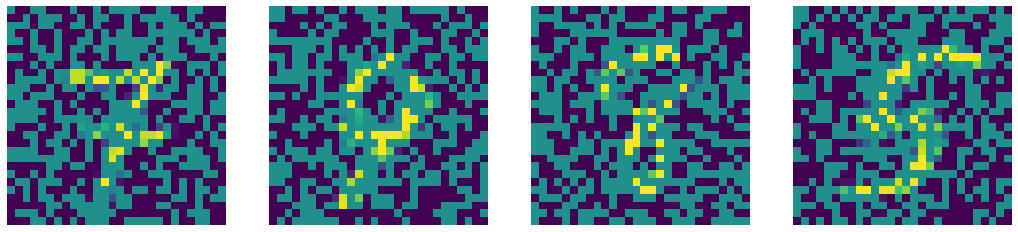

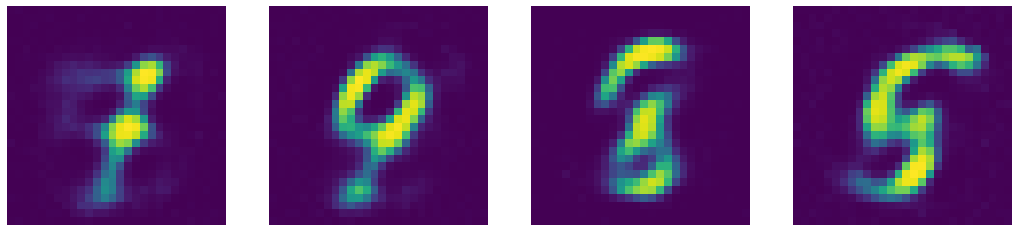

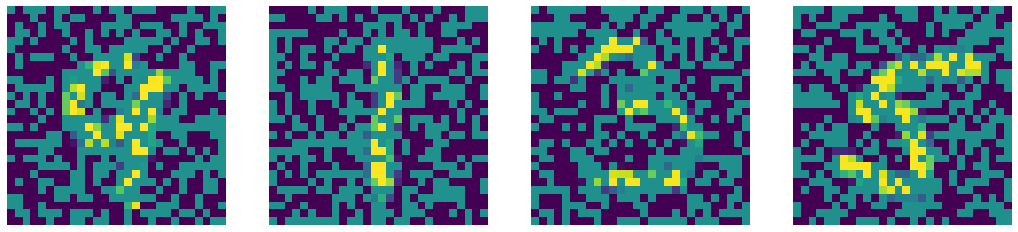

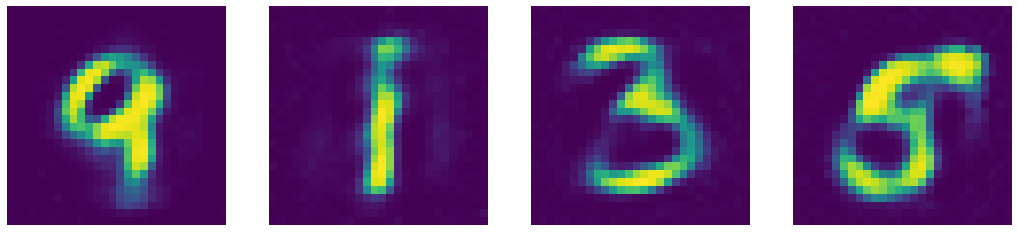

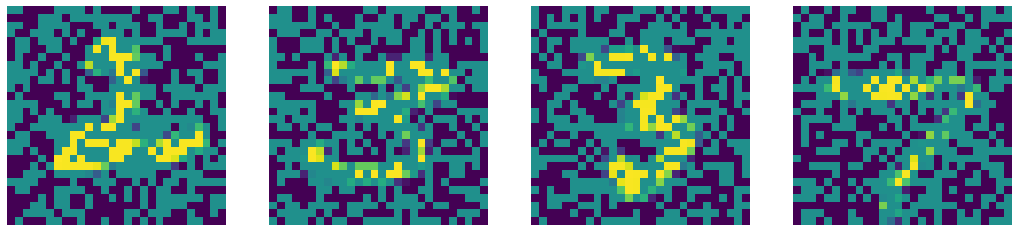

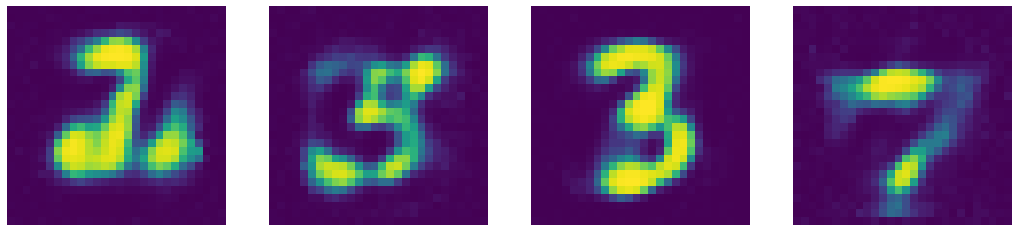

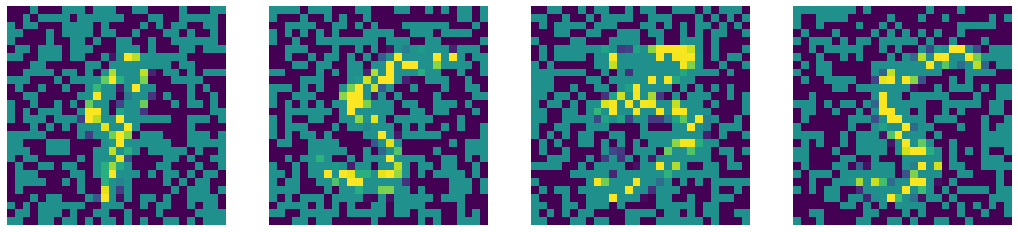

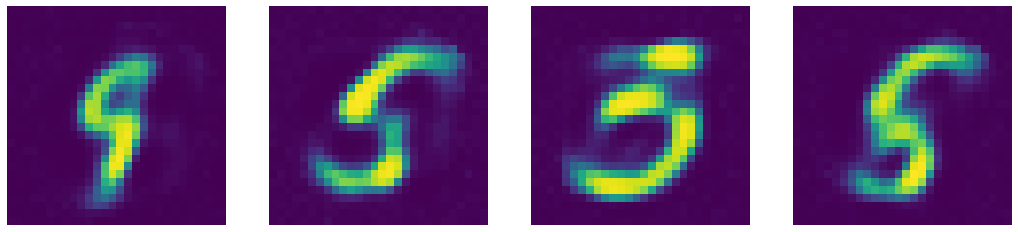

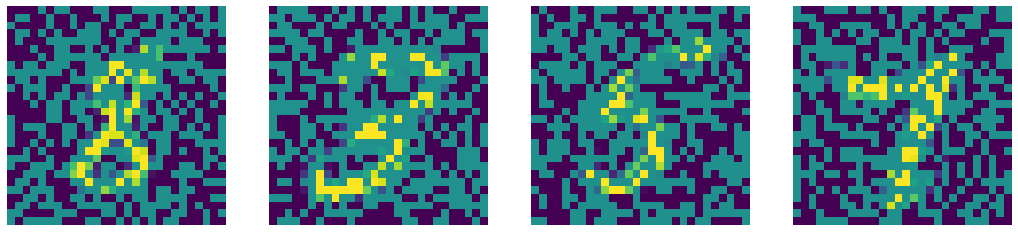

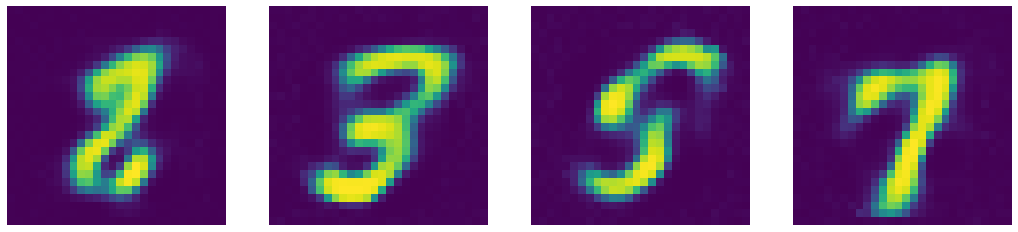

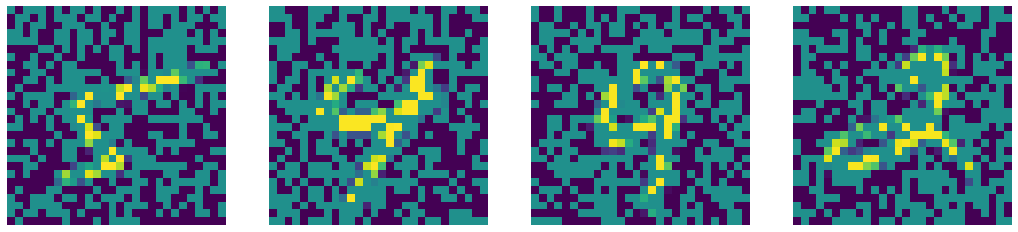

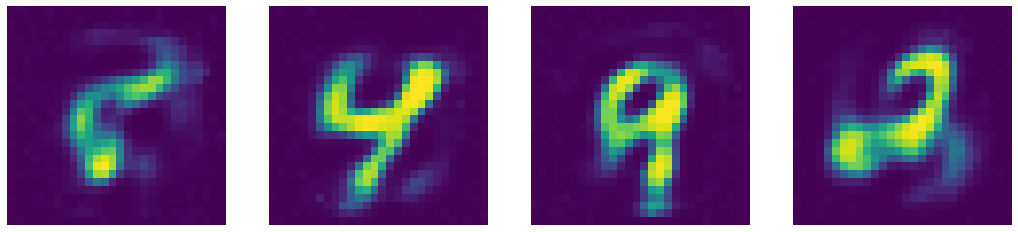

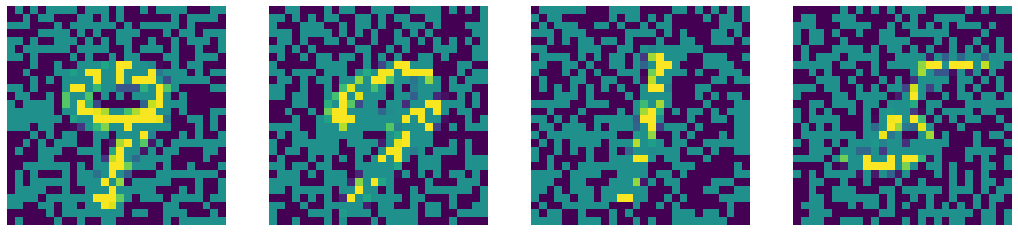

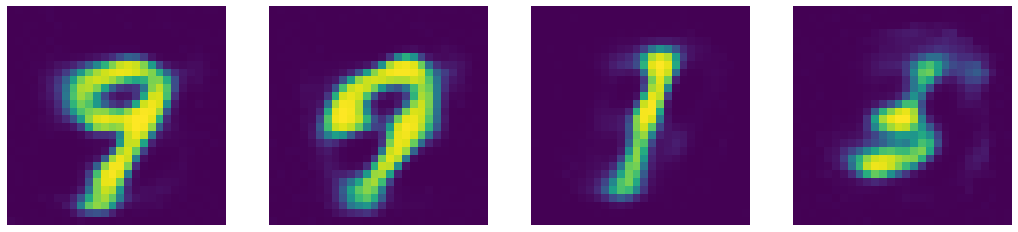

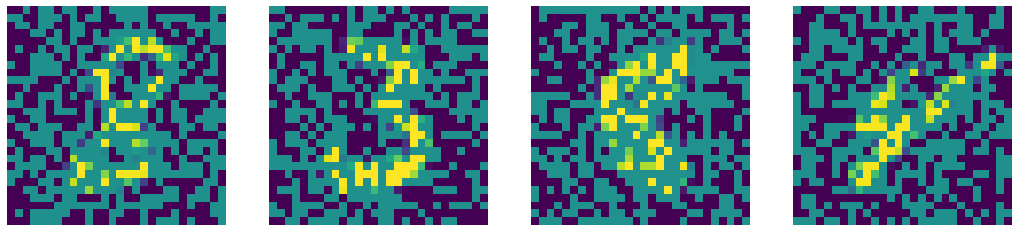

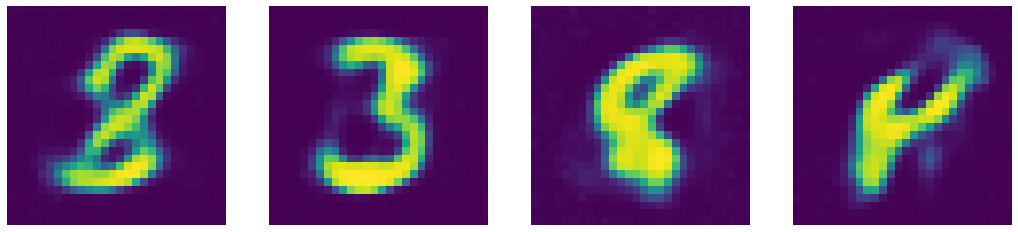

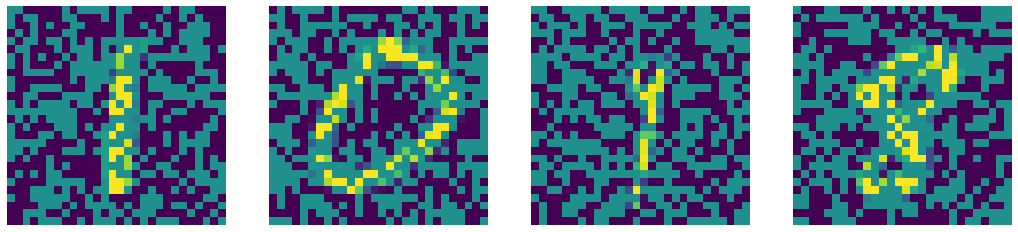

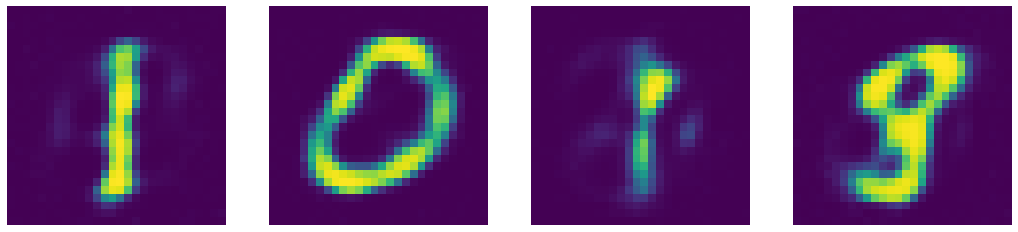

In [ ]:
num_epochs = 10
do = nn.Dropout()
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)
        # ===================forward=====================
        output = model(img_bad)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)

9. Visualise a few kernels of the encoder :


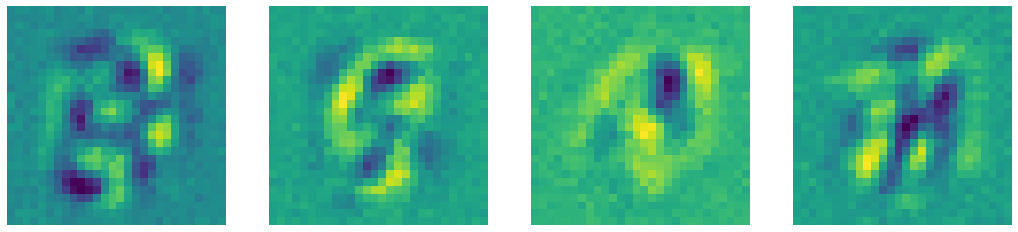

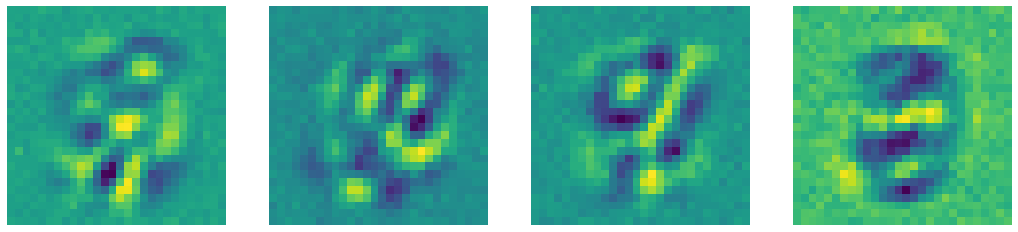

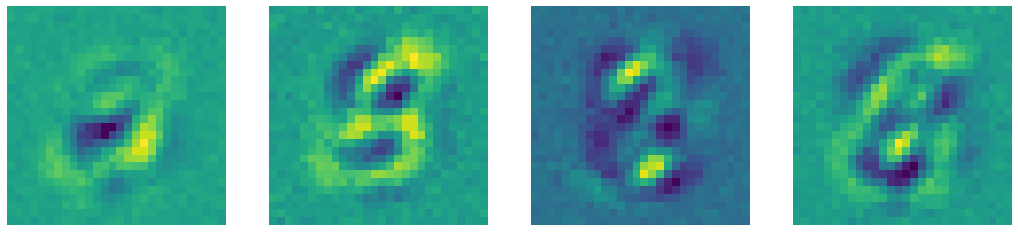

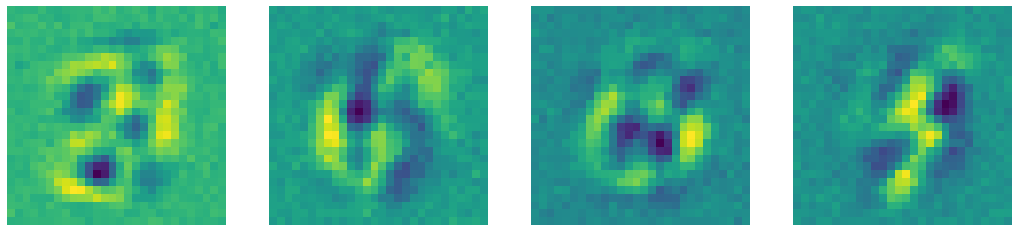

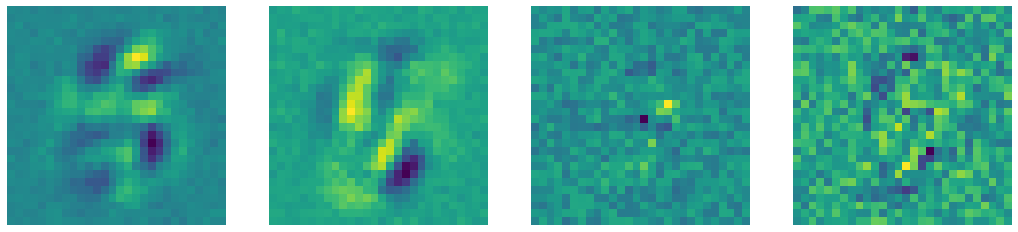

In [ ]:
display_images(None, model.encoder[0].weight, 5)

10. Analyse the obtained results.
<center> <h2> Réponse </center>

---



Ils sont en effet assez similaires, mais pas exactement les mêmes. On le remarque plus clairement dans le dernier encodeur. Comme il s'agissait d'une tâche simple, notre encodeur automatique a plutôt bien fonctionné.

---





11. Changes the parameters of the Autoencoder and analyse theirs impact. Conclude.

<center> <h2> Réponse </center>

---


**Il y a 4 hyperparamètres que nous devons définir avant de former un auto-encodeur :**

*  Taille du code : nombre de nœuds dans la couche intermédiaire. Une taille plus petite entraîne plus de compression.

*  Nombre de couches : l'auto-encodeur peut être aussi profond que nous le souhaitons. Dans la figure ci-dessus, nous avons 2 couches dans l'encodeur et le décodeur, sans tenir compte de l'entrée et de la sortie.

*  Nombre de nœuds par couche : l'architecture d'auto-encodeur sur laquelle nous travaillons est appelée auto- encodeur empilé puisque les couches sont empilées les unes après les autres. Habituellement, les encodeurs automatiques empilés ressemblent à un "sandwitch". Le nombre de nœuds par couche diminue avec chaque couche suivante du codeur et augmente à nouveau dans le décodeur. De plus, le décodeur est symétrique au codeur en termes de structure de couche. Comme indiqué ci-dessus, cela n'est pas nécessaire et nous avons un contrôle total sur ces paramètres.

*  Fonction de perte : nous utilisons soit l' erreur quadratique moyenne (mse) , soit l'entropie croisée binaire . Si les valeurs d'entrée sont dans la plage [0, 1], nous utilisons généralement l'entropie croisée, sinon nous utilisons l'erreur quadratique moyenne.

---



change TANH by Relu , and d to 100

In [ ]:

d = 500 #activer ce ligne et recompiler pour le denoising autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

epoch [1/10], loss:1.0992
epoch [2/10], loss:1.1008
epoch [3/10], loss:1.0968
epoch [4/10], loss:1.0980
epoch [5/10], loss:1.0932
epoch [6/10], loss:1.1013
epoch [7/10], loss:1.1021
epoch [8/10], loss:1.0950
epoch [9/10], loss:1.1047
epoch [10/10], loss:1.0928


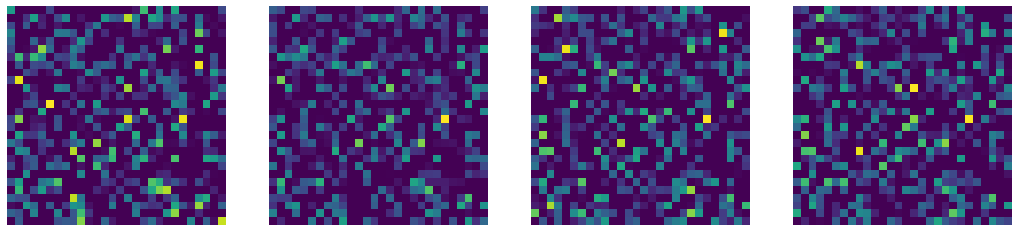

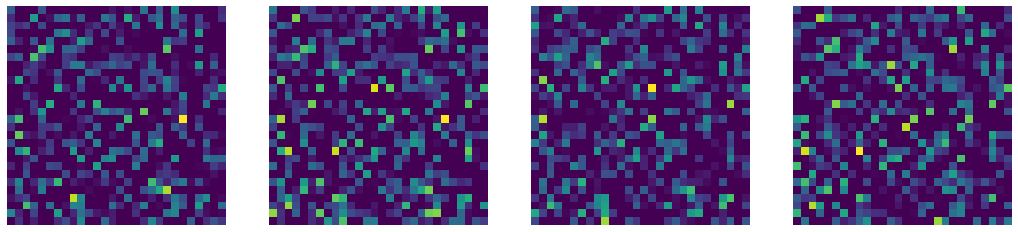

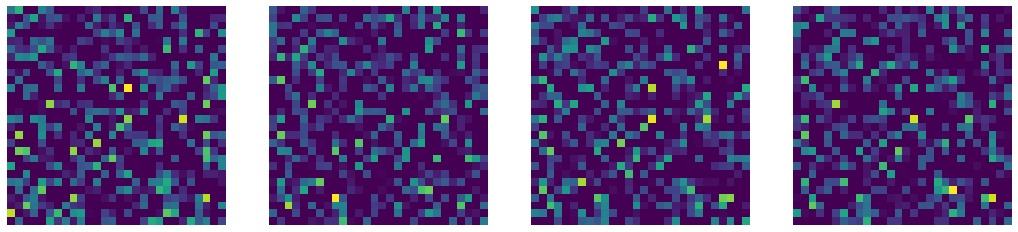

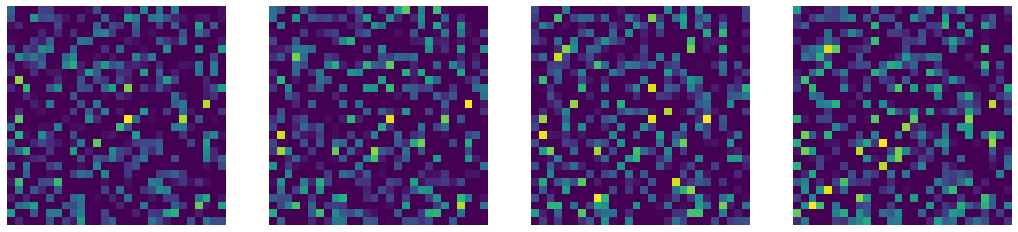

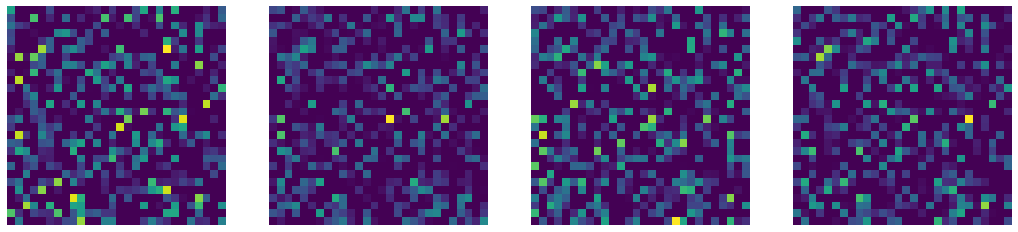

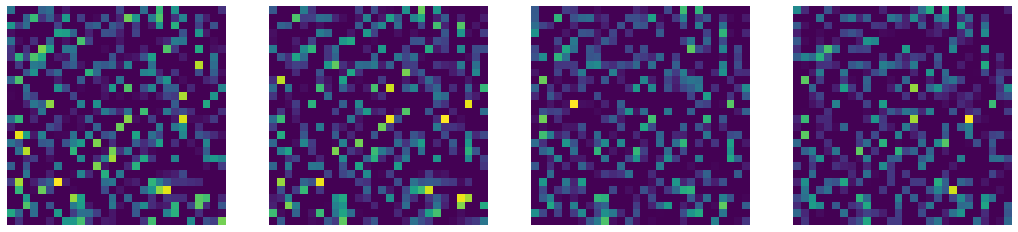

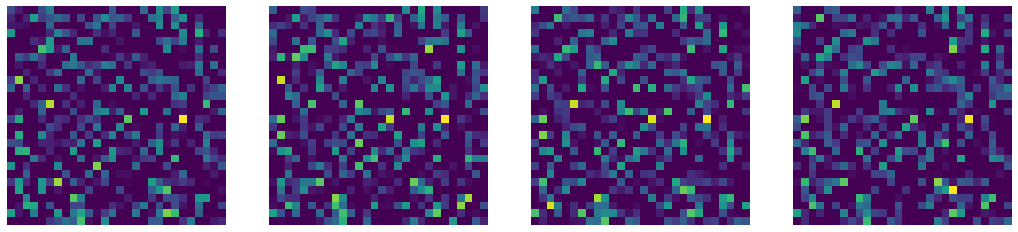

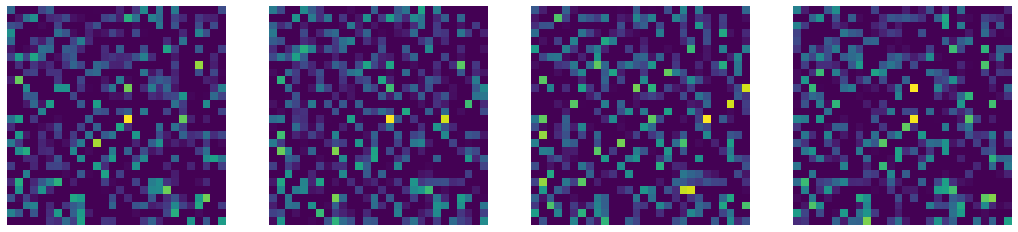

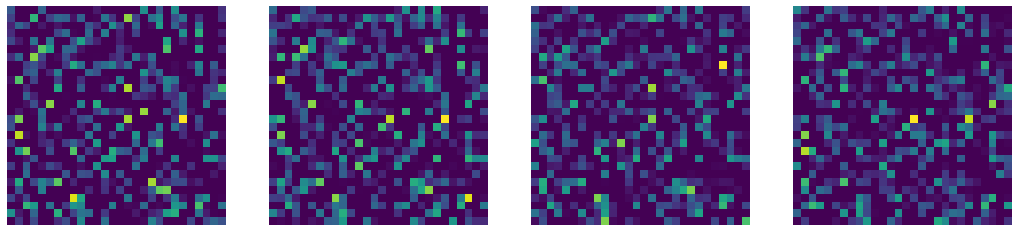

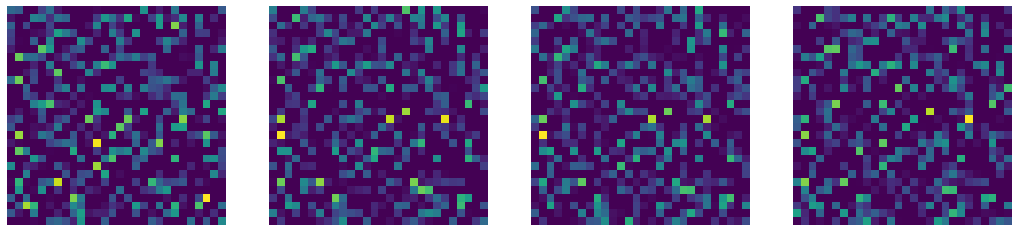

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)

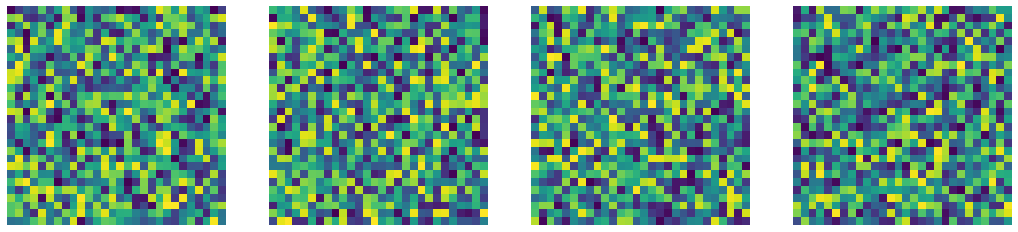

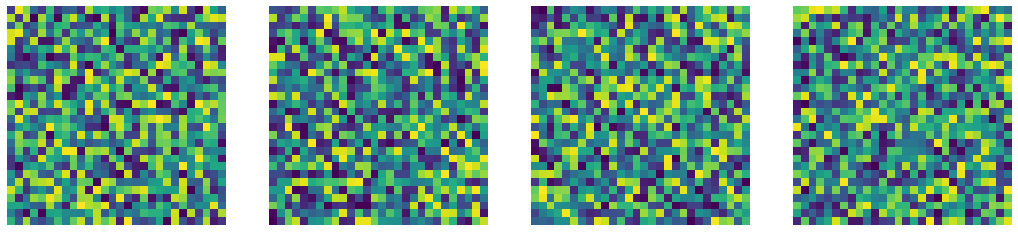

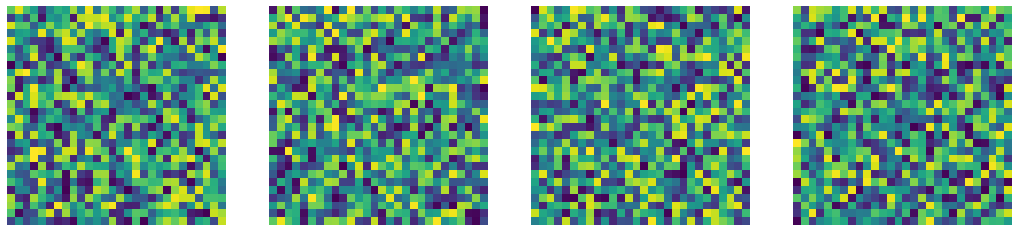

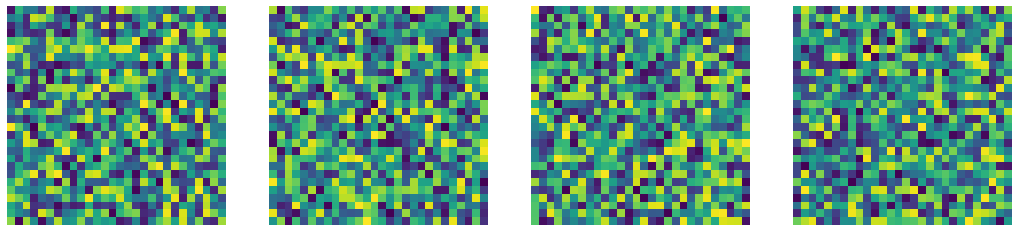

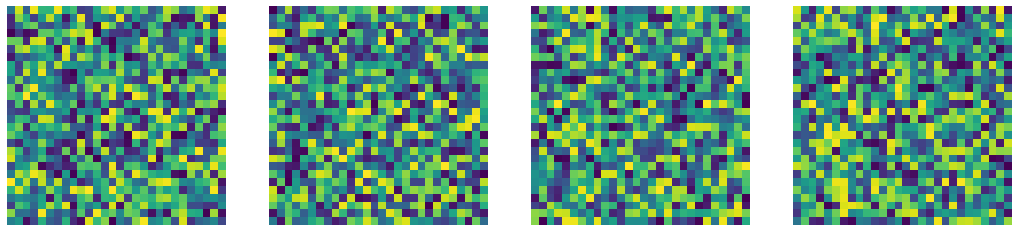

In [ ]:
display_images(None, model.encoder[0].weight, 5)

<center><h2>Réponse</h2></center>

**Les résultats ne sont pas ce qui est demandé d’un encodeur, le décodeur ne réussite pas à donner des résultats similaires à l’entrée de l’encodeur, donc les information sont perdues (biaisés).**